# Maritime Case Quality Evaluation Notebook

In [1]:
import os
import json
import pandas as pd
import time
from pathlib import Path
from tqdm.notebook import tqdm
import google.generativeai as genai
from IPython.display import display, Markdown
from dotenv import load_dotenv

## Step 1: Load all Generated Cases into a DataFrame

In [12]:
def load_cases_into_dataframe(cases_dir="Output/Generated_Cases"):
    """Load all JSON case files in the directory into a DataFrame"""
    cases = []
    path = Path(cases_dir)
    
    # Check if directory exists
    if not path.exists():
        print(f"⚠️ Directory not found: {path.absolute()}")
        print(f"Current working directory: {Path.cwd()}")
        # Try to find the directory
        potential_paths = list(Path.cwd().glob("**/Generated_Cases"))
        if potential_paths:
            print(f"Found potential case directories: {potential_paths}")
            path = potential_paths[0]
            print(f"Using: {path}")
    
    # Find all JSON files
    case_files = list(path.glob("*.json"))
    print(f"Found {len(case_files)} case files in {path.absolute()}")
    
    if len(case_files) == 0:
        print("⚠️ No JSON files found. Checking file extensions...")
        all_files = list(path.glob("*"))
        extensions = set(f.suffix for f in all_files)
        print(f"Files with these extensions found: {extensions}")
    
    for file_path in tqdm(case_files):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                case_data = json.load(f)
                
                # Extract the fields we care about with fallbacks
                case_entry = {
                    "case_id": case_data.get("case_id", ""),
                    "title": case_data.get("title", "").replace(': "', '').replace('"', ''),  # Clean title format
                    "enhanced_case": case_data.get("enhanced_case", ""),
                    "solution": case_data.get("solution", ""),
                    "file_path": str(file_path)
                }
                cases.append(case_entry)
                
        except json.JSONDecodeError as e:
            print(f"JSON error in {file_path}: {e}")
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
    
    # Create DataFrame with safety check
    if not cases:
        print("⚠️ No cases were loaded. Creating empty DataFrame with required columns.")
        return pd.DataFrame(columns=["case_id", "title", "enhanced_case", "solution", "file_path", 
                                     "enhanced_case_length", "solution_length"])
    
    df = pd.DataFrame(cases)
    print(f"Loaded {len(df)} cases into DataFrame")
    
    # Add length columns for analysis
    df["enhanced_case_length"] = df["enhanced_case"].apply(len)
    df["solution_length"] = df["solution"].apply(len)
    
    return df

In [13]:


# Load the cases
cases_df = load_cases_into_dataframe("/Users/max/Documents/Code/magdeburg25/Output/Generated_Cases")

# Show basic statistics
display(cases_df[["case_id", "title", "enhanced_case_length", "solution_length"]].head())



Found 307 case files in /Users/max/Documents/Code/magdeburg25/Output/Generated_Cases


  0%|          | 0/307 [00:00<?, ?it/s]

Loaded 307 cases into DataFrame


,case_id,title,enhanced_case_length,solution_length
0,case-20250329-203754-mtqgzd,: Strangled Supply Lines: Navigating Baltic Po...,7356,178919
1,case-20250329-210405-wqz1op,:\n\nBaltSea Seafoods: Navigating Logistical S...,5790,8809
2,case-20250329-002501-xcy2qu,: Navigating the Baltic Supply Chain: A Plywoo...,8570,74328
3,case-20250329-001222-kqjau3,: The Baltic Bottleneck: Navigating Congestion...,6749,14069
4,case-20250330-080637-j1kold,**Tallinn's Trade Winds: Navigating Peak Seaso...,6490,205247


In [14]:
cases_df.head()

,case_id,title,enhanced_case,solution,file_path,enhanced_case_length,solution_length
0,case-20250329-203754-mtqgzd,: Strangled Supply Lines: Navigating Baltic Po...,"**Scenario:**\n\nNordic Seafood Imports (NSI),...",## Executive Summary\n\nNordic Seafood Imports...,/Users/max/Documents/Code/magdeburg25/Output/G...,7356,178919
1,case-20250329-210405-wqz1op,:\n\nBaltSea Seafoods: Navigating Logistical S...,"**Scenario:** BaltSea Seafoods, a rapidly grow...",## Executive Summary\n\nBaltSea Seafoods is fa...,/Users/max/Documents/Code/magdeburg25/Output/G...,5790,8809
2,case-20250329-002501-xcy2qu,: Navigating the Baltic Supply Chain: A Plywoo...,"**Scenario:** Nordic Wood Exports (NWE), a mid...",## Executive Summary\n\nNordic Wood Exports (N...,/Users/max/Documents/Code/magdeburg25/Output/G...,8570,74328
3,case-20250329-001222-kqjau3,: The Baltic Bottleneck: Navigating Congestion...,"**Scenario:**\n\nOceanWave Logistics, a rapidl...",## Executive Summary\n\nOceanWave Logistics is...,/Users/max/Documents/Code/magdeburg25/Output/G...,6749,14069
4,case-20250330-080637-j1kold,**Tallinn's Trade Winds: Navigating Peak Seaso...,"**Scenario:** BaltiCon Logistics, a mid-sized ...",## Executive Summary\n\nBaltiCon Logistics is ...,/Users/max/Documents/Code/magdeburg25/Output/G...,6490,205247


### Cleaning and Normalizing Text in the DataFrame

In [15]:
import re

def normalize_text(text):
    """Clean and normalize text content"""
    import re
    
    if not isinstance(text, str):
        return ""
    
    # Remove leading/trailing whitespace
    text = text.strip()
    
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    
    # Fix common markdown spacing issues
    text = re.sub(r'\s+\*\s+', ' * ', text)
    text = re.sub(r'\s+:\s+', ': ', text)
    
    return text

def clean_title(title):
    """Clean title format by removing prefixes and quotes"""
    if not isinstance(title, str):
        return ""
    
    # Remove leading ': "' and trailing '"'
    title = re.sub(r'^:\s*"', '', title)
    title = re.sub(r'"$', '', title)
    
    # Remove any other quote patterns
    title = title.replace('"', '')
    
    # Normalize the cleaned title
    title = normalize_text(title)
    
    return title

def clean_dataframe_text(df):
    """Apply text cleaning to all relevant columns in the DataFrame"""
    # Create a copy to avoid modifying the original
    cleaned_df = df.copy()
    
    # Clean titles
    if 'title' in cleaned_df.columns:
        cleaned_df['title'] = cleaned_df['title'].apply(clean_title)
    
    # Normalize text in content columns
    text_columns = ['enhanced_case', 'solution']
    for col in text_columns:
        if col in cleaned_df.columns:
            cleaned_df[col] = cleaned_df[col].apply(normalize_text)
    
    return cleaned_df



In [16]:
# Apply cleaning to your DataFrame
cleaned_cases_df = clean_dataframe_text(cases_df)

# Show a comparison of before and after
comparison = pd.DataFrame({
    'original_title': cases_df['title'].head(),
    'cleaned_title': cleaned_cases_df['title'].head()
})
display(comparison)


,original_title,cleaned_title
0,: Strangled Supply Lines: Navigating Baltic Po...,: Strangled Supply Lines: Navigating Baltic Po...
1,:\n\nBaltSea Seafoods: Navigating Logistical S...,: BaltSea Seafoods: Navigating Logistical Stor...
2,: Navigating the Baltic Supply Chain: A Plywoo...,: Navigating the Baltic Supply Chain: A Plywoo...
3,: The Baltic Bottleneck: Navigating Congestion...,: The Baltic Bottleneck: Navigating Congestion...
4,**Tallinn's Trade Winds: Navigating Peak Seaso...,**Tallinn's Trade Winds: Navigating Peak Seaso...


In [17]:
# Replace the original DataFrame with cleaned one
cases_df = cleaned_cases_df

### Fixing Title Prefixes and Displaying DataFrame Sample

In [18]:
def fix_title_prefixes(title):
    """Aggressively clean title format by removing all common prefixes and quotes"""
    import re
    
    if not isinstance(title, str):
        return ""
    
    # Remove common patterns at beginning
    patterns = [
        r'^:\s*',          # Leading colon with space
        r'^"\s*',          # Leading quote with space
        r'^:\s*"',         # Leading colon+quote with space
        r'^Title:\s*',     # "Title:" prefix
        r'^Case Title:\s*' # "Case Title:" prefix
    ]
    
    # Apply each pattern
    for pattern in patterns:
        title = re.sub(pattern, '', title)
    
    # Remove quotes at beginning and end
    title = re.sub(r'^"', '', title)
    title = re.sub(r'"$', '', title)
    
    # Remove any remaining quotes
    title = title.replace('"', '')
    title = title.replace("'", "")
    
    # Clean up whitespace
    title = title.strip()
    
    return title


In [19]:
# Apply the improved cleaning to titles
cases_df['title'] = cases_df['title'].apply(fix_title_prefixes)

In [20]:


# Function to display abbreviated sample of DataFrame
def display_df_sample(df, rows=2, max_length=200):
    """Display a sample of DataFrame with text columns abbreviated"""
    sample = df.head(rows).copy()
    
    # Abbreviate long text columns
    for col in sample.columns:
        if sample[col].dtype == 'object':  # Text columns
            sample[col] = sample[col].apply(
                lambda x: f"{str(x)[:max_length]}..." if isinstance(x, str) and len(str(x)) > max_length else x
            )
    
    # Display the sample
    display(sample)
    
    # Also print as JSON for sharing
    print("\nJSON representation of first 2 rows:")
    sample_json = sample.to_json(orient='records', indent=2)
    print(sample_json[:2000])  # Limit output if too long



In [21]:
# Show a sample of the fixed DataFrame
display_df_sample(cases_df, rows=2, max_length=200)

,case_id,title,enhanced_case,solution,file_path,enhanced_case_length,solution_length
0,case-20250329-203754-mtqgzd,Strangled Supply Lines: Navigating Baltic Port...,"**Scenario:** Nordic Seafood Imports (NSI), a ...",## Executive Summary Nordic Seafood Imports (N...,/Users/max/Documents/Code/magdeburg25/Output/G...,7356,178919
1,case-20250329-210405-wqz1op,BaltSea Seafoods: Navigating Logistical Storms...,"**Scenario:** BaltSea Seafoods, a rapidly grow...",## Executive Summary BaltSea Seafoods is facin...,/Users/max/Documents/Code/magdeburg25/Output/G...,5790,8809



JSON representation of first 2 rows:
[
  {
    "case_id":"case-20250329-203754-mtqgzd",
    "title":"Strangled Supply Lines: Navigating Baltic Port Congestion and Seafood Spoilage Risks",
    "enhanced_case":"**Scenario:** Nordic Seafood Imports (NSI), a leading importer of frozen seafood into Scandinavia and the Baltic states, is facing a critical disruption to its container shipping operations. NSI sourc...",
    "solution":"## Executive Summary Nordic Seafood Imports (NSI) is facing a critical supply chain disruption due to congestion at Baltic ports, leading to reefer container shortages, increased costs, and quality co...",
    "file_path":"\/Users\/max\/Documents\/Code\/magdeburg25\/Output\/Generated_Cases\/__Strangled_Supply_Lines__Navigating_Baltic_Port_Congestion_and_Seafood_Spoilage_Risks.json",
    "enhanced_case_length":7356,
    "solution_length":178919
  },
  {
    "case_id":"case-20250329-210405-wqz1op",
    "title":"BaltSea Seafoods: Navigating Logistical Storms in the

In [22]:
# Save to parquet for backup
output_dir = Path("/Users/max/Documents/Code/magdeburg25/Data/GeneratedCases")
output_dir.mkdir(parents=True, exist_ok=True)
parquet_path = output_dir / "generated_cases.parquet"
cases_df.to_parquet(parquet_path)
print(f"Saved cases to {parquet_path}")

Saved cases to /Users/max/Documents/Code/magdeburg25/Data/GeneratedCases/generated_cases.parquet


## Step 2: Create the Evaluation Framework

In [23]:
import os
import google.generativeai as genai
from dotenv import load_dotenv

### 2.1 Select the model

In [31]:
# At the top of your evaluation function, list available models
available_models = [m.name for m in genai.list_models() if "generateContent" in m.supported_generation_methods]
print("Available models:", available_models)



Available models: ['models/gemini-1.0-pro-vision-latest', 'models/gemini-pro-vision', 'models/gemini-1.5-pro-latest', 'models/gemini-1.5-pro-001', 'models/gemini-1.5-pro-002', 'models/gemini-1.5-pro', 'models/gemini-1.5-flash-latest', 'models/gemini-1.5-flash-001', 'models/gemini-1.5-flash-001-tuning', 'models/gemini-1.5-flash', 'models/gemini-1.5-flash-002', 'models/gemini-1.5-flash-8b', 'models/gemini-1.5-flash-8b-001', 'models/gemini-1.5-flash-8b-latest', 'models/gemini-1.5-flash-8b-exp-0827', 'models/gemini-1.5-flash-8b-exp-0924', 'models/gemini-2.5-pro-exp-03-25', 'models/gemini-2.0-flash-exp', 'models/gemini-2.0-flash', 'models/gemini-2.0-flash-001', 'models/gemini-2.0-flash-exp-image-generation', 'models/gemini-2.0-flash-lite-001', 'models/gemini-2.0-flash-lite', 'models/gemini-2.0-flash-lite-preview-02-05', 'models/gemini-2.0-flash-lite-preview', 'models/gemini-2.0-pro-exp', 'models/gemini-2.0-pro-exp-02-05', 'models/gemini-exp-1206', 'models/gemini-2.0-flash-thinking-exp-01-21

In [40]:
# Then use a model that's definitely available
model = genai.GenerativeModel(model_name="gemini-2.0-flash-exp")  # Try an older version if 2.0 isn't working

In [30]:
# Configure the Google Generative AI client
load_dotenv()
api_key = os.getenv("GOOGLE_API_KEY")
genai.configure(api_key=api_key)

# Define our evaluation metrics
EVALUATION_METRICS = {
    "realism_score": "Realism Score (1-10): How realistic and plausible the scenario is in maritime logistics",
    "complexity_score": "Complexity Score (1-10): How well the case presents appropriate challenges and depth",
    "educational_value": "Educational Value (1-10): How useful this case is for teaching maritime logistics concepts",
    "solution_quality": "Solution Quality (1-10): How comprehensive, accurate and well-structured the solution is"
}

def create_evaluation_prompt(case_title, case_content, solution_content):
    """Create a prompt for the LLM to evaluate case quality"""
    
    prompt = f"""
    # Maritime Logistics Case Evaluation
    
    You are a maritime logistics expert tasked with evaluating the quality of a case study and its solution.
    Your evaluation should focus on both the scenario's realism and the solution's quality.
    
    ## Case Study to Evaluate:
    
    Title: {case_title}
    
    {case_content[:3000]}  # Using first 3000 chars for case content
    
    ## Solution to Evaluate:
    
    {solution_content[:3000]}  # Using first 3000 chars of solution
    
    ## Evaluation Guidelines:
    
    **Important Context:**
    1. This case is fictional but based on real logistics concepts and regulations
    2. Company names, specific vessels, and exact dates are fictional and should not be fact-checked
    3. However, maritime procedures, regulations, port operations, and logistics concepts should be evaluated based on your knowledge
    4. Use your expert knowledge to assess the accuracy of maritime logistics concepts presented
    
    ## Evaluation Criteria:
    
    1. **Realism Score (1-10)**: Evaluate how realistic the scenario is in terms of:
       - Maritime logistics operations and challenges
       - Supply chain procedures and documentation
       - Port operations and customs procedures
    
    2. **Complexity Score (1-10)**: Evaluate the case's complexity:
       - Multiple interrelated challenges
       - Appropriate difficulty level for professional education
       - Nuanced considerations that require analysis
    
    3. **Educational Value (1-10)**: Assess how valuable this case would be for teaching:
       - Key maritime logistics concepts
       - Problem-solving in international trade
       - Understanding of shipping procedures and documentation
    
    4. **Solution Quality (1-10)**: Evaluate the solution for:
       - Comprehensiveness (addresses all aspects of the problem)
       - Accuracy (correct procedures and regulations)
       - Structure and clarity
       - Practicality and effectiveness
    
    ## Required Output Format:
    
    Provide your analysis in this JSON format:
    ```
    {{
        "realism_score": X, // 1-10
        "complexity_score": X, // 1-10
        "educational_value": X, // 1-10
        "solution_quality": X, // 1-10
        "overall_qualification": "QUALIFIED" or "NOT QUALIFIED",
        "evaluation_summary": "Brief professional assessment of the case and solution quality",
        "improvement_suggestions": ["Suggestion 1", "Suggestion 2", ...]
    }}
    ```
    
    Focus your evaluation on critically assessing the logistics aspects of the case. Be strict but fair.
    """
    
    return prompt


In [41]:
def evaluate_case_with_llm(case_title, case_content, solution_content):
    """Evaluate a case using the LLM (without search grounding)"""
    
    prompt = create_evaluation_prompt(case_title, case_content, solution_content)
    
    try:
        # Using Google's Gemini model WITHOUT search tools
        model = genai.GenerativeModel(
            model_name="gemini-2.0-flash-exp"
            # Removed: tools=[genai.web_search.WebSearchTool()]
        )
        
        response = model.generate_content(
            prompt,
            generation_config={"temperature": 0.2}  # Keep temperature low for evaluation
            # Removed: tool_config={"web_search": {"priority": "auto"}}
        )
        
        # Parse the JSON response
        response_text = response.text
        
        # Extract JSON from the response (handling potential markdown formatting)
        import re
        json_match = re.search(r'```(?:json)?\s*(.*?)\s*```', response_text, re.DOTALL)
        
        if json_match:
            json_str = json_match.group(1)
            try:
                return json.loads(json_str)
            except:
                print("Error parsing JSON from response")
                return None
        else:
            print("No JSON found in response")
            return None
            
    except Exception as e:
        print(f"Error evaluating case: {e}")
        return None

In [38]:
def evaluate_all_cases(df, sample_size=None, delay_seconds=10):
    """Evaluate all cases in the DataFrame and add results as columns"""
    
    if sample_size:
        # Use a random sample if specified
        cases_to_evaluate = df.sample(sample_size)
        print(f"Evaluating a random sample of {sample_size} cases")
    else:
        cases_to_evaluate = df
        print(f"Evaluating all {len(df)} cases")
    
    # Prepare results columns
    results = []
    
    for idx, row in tqdm(cases_to_evaluate.iterrows(), total=len(cases_to_evaluate)):
        print(f"\nEvaluating case: {row['title']}")
        
        evaluation = evaluate_case_with_llm(
            row["title"],
            row["enhanced_case"],
            row["solution"]
        )
        
        if evaluation:
            # Add case_id to the evaluation results
            evaluation["case_id"] = row["case_id"]
            results.append(evaluation)
            
            # Display the evaluation result
            print(f"Evaluation for '{row['title']}':")
            print(f"Realism: {evaluation.get('realism_score')}/10")
            print(f"Complexity: {evaluation.get('complexity_score')}/10")
            print(f"Educational Value: {evaluation.get('educational_value')}/10")
            print(f"Solution Quality: {evaluation.get('solution_quality')}/10")
            print(f"Qualification: {evaluation.get('overall_qualification')}")
            print(f"Summary: {evaluation.get('evaluation_summary')}")
        else:
            print(f"Failed to evaluate case: {row['case_id']}")
        
        # Sleep between API calls to avoid rate limits
        if idx < len(cases_to_evaluate) - 1:  # Don't sleep after the last item
            print(f"Waiting {delay_seconds} seconds before next evaluation...")
            time.sleep(delay_seconds)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Merge results back to the original DataFrame
    merged_df = pd.merge(df, results_df, on="case_id", how="left")
    
    return merged_df

Now let's run the evaluation on a small sample to test it:

In [39]:
# Run evaluation on a small sample first to test
sample_size = 2  # Start with a small sample
evaluated_cases_df = evaluate_all_cases(cases_df, sample_size=sample_size, delay_seconds=10)

# Save the test evaluation results
test_eval_path = output_dir / "test_evaluated_cases.parquet"
evaluated_cases_df.to_parquet(test_eval_path)
print(f"Saved test evaluation to {test_eval_path}")

Evaluating a random sample of 2 cases


  0%|          | 0/2 [00:00<?, ?it/s]


Evaluating case: **The Baltic Seafood Squeeze: Navigating Congestion, Costs, and Compliance in Nordic Imports**
Evaluation for '**The Baltic Seafood Squeeze: Navigating Congestion, Costs, and Compliance in Nordic Imports**':
Realism: 9/10
Complexity: 8/10
Educational Value: 9/10
Solution Quality: 7/10
Qualification: QUALIFIED
Summary: The case study presents a highly realistic and relevant scenario reflecting common challenges in modern maritime logistics, particularly for perishable goods imported into Northern Europe. The complexities involving transshipment delays, feeder network reliability, reefer management, and cost pressures are accurately portrayed. The educational value is high, covering key concepts like network design, port congestion impacts, and specialized cargo handling. The proposed solution outlines a logical, multi-faceted approach addressing the core issues identified. However, the solution (as presented in the truncated text) lacks depth in certain areas, particul

## Step 3: Run the Evaluation

In [42]:
def evaluate_all_cases(df, sample_size=None, delay_seconds=7):
    """Evaluate all cases in the DataFrame and add results as columns"""
    
    if sample_size:
        # Use a random sample if specified
        cases_to_evaluate = df.sample(sample_size)
        print(f"Evaluating a random sample of {sample_size} cases")
    else:
        cases_to_evaluate = df
        print(f"Evaluating all {len(df)} cases")
    
    # Prepare results columns
    results = []
    
    for idx, row in tqdm(cases_to_evaluate.iterrows(), total=len(cases_to_evaluate)):
        print(f"\nEvaluating case: {row['title']}")
        
        evaluation = evaluate_case_with_llm(
            row["title"],
            row["enhanced_case"],
            row["solution"]
        )
        
        if evaluation:
            # Add case_id to the evaluation results
            evaluation["case_id"] = row["case_id"]
            results.append(evaluation)
            
            # Display the evaluation result
            print(f"Evaluation for '{row['title']}':")
            print(f"Realism: {evaluation.get('realism_score')}/10")
            print(f"Complexity: {evaluation.get('complexity_score')}/10")
            print(f"Educational Value: {evaluation.get('educational_value')}/10")
            print(f"Solution Quality: {evaluation.get('solution_quality')}/10")
            print(f"Qualification: {evaluation.get('overall_qualification')}")
            print(f"Summary: {evaluation.get('evaluation_summary')}")
        else:
            print(f"Failed to evaluate case: {row['case_id']}")
        
        # Sleep between API calls to avoid rate limits
        if idx < len(cases_to_evaluate) - 1:  # Don't sleep after the last item
            print(f"Waiting {delay_seconds} seconds before next evaluation...")
            time.sleep(delay_seconds)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Merge results back to the original DataFrame
    merged_df = pd.merge(df, results_df, on="case_id", how="left")
    
    return merged_df



In [43]:
import subprocess
from tqdm.notebook import tqdm

# Start caffeinate to prevent Mac from sleeping
print("Starting caffeinate to prevent Mac from sleeping...")
caffeinate_process = subprocess.Popen(["caffeinate", "-i", "-d", "-m"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

try:
    # Run the evaluation with improved progress tracking
    print(f"Beginning evaluation of {len(cases_df)} cases with {7}s delay between calls")
    print(f"Estimated time: ~{len(cases_df) * 7 / 60:.1f} minutes")
    
    # Create a timestamp for the run
    import datetime
    start_time = datetime.datetime.now()
    timestamp = start_time.strftime("%Y%m%d_%H%M%S")
    
    # Run evaluation
    evaluated_cases_df = evaluate_all_cases(cases_df, sample_size=None, delay_seconds=7)
    
    # Calculate and display statistics
    end_time = datetime.datetime.now()
    duration = (end_time - start_time).total_seconds() / 60
    
    print(f"\n✅ Evaluation complete!")
    print(f"Started: {start_time.strftime('%H:%M:%S')}")
    print(f"Ended: {end_time.strftime('%H:%M:%S')}")
    print(f"Duration: {duration:.2f} minutes")
    
    # Save the results to a new parquet file with timestamp
    evaluated_parquet_path = output_dir / f"evaluated_cases_{timestamp}.parquet"
    evaluated_cases_df.to_parquet(evaluated_parquet_path)
    print(f"Saved evaluated cases to {evaluated_parquet_path}")
    
finally:
    # Make sure to terminate caffeinate when we're done
    print("Terminating caffeinate - your Mac can sleep again...")
    caffeinate_process.terminate()

Starting caffeinate to prevent Mac from sleeping...
Beginning evaluation of 307 cases with 7s delay between calls
Estimated time: ~35.8 minutes
Evaluating all 307 cases


  0%|          | 0/307 [00:00<?, ?it/s]


Evaluating case: Strangled Supply Lines: Navigating Baltic Port Congestion and Seafood Spoilage Risks
Evaluation for 'Strangled Supply Lines: Navigating Baltic Port Congestion and Seafood Spoilage Risks':
Realism: 8/10
Complexity: 7/10
Educational Value: 9/10
Solution Quality: 8/10
Qualification: QUALIFIED
Summary: The case study presents a realistic scenario of port congestion impacting a seafood importer. The challenges related to reefer container availability, demurrage, and potential spoilage are well-articulated and reflect common issues in maritime logistics. The solution is comprehensive, addressing immediate concerns while also proposing long-term strategies for risk mitigation. The inclusion of regulatory references enhances the solution's credibility. However, some aspects of the solution could be more detailed, particularly regarding the financial implications of each step.
Waiting 7 seconds before next evaluation...

Evaluating case: BaltSea Seafoods: Navigating Logistical

## Step 4: Analyze the Results

Overall Evaluation Metrics:
realism_score: Avg = 8.11, Median = 8.00
complexity_score: Avg = 7.12, Median = 7.00
educational_value: Avg = 8.71, Median = 9.00
solution_quality: Avg = 7.74, Median = 8.00

Qualification Results:
overall_qualification
QUALIFIED    304
Name: count, dtype: int64
Qualification Rate: 99.02%


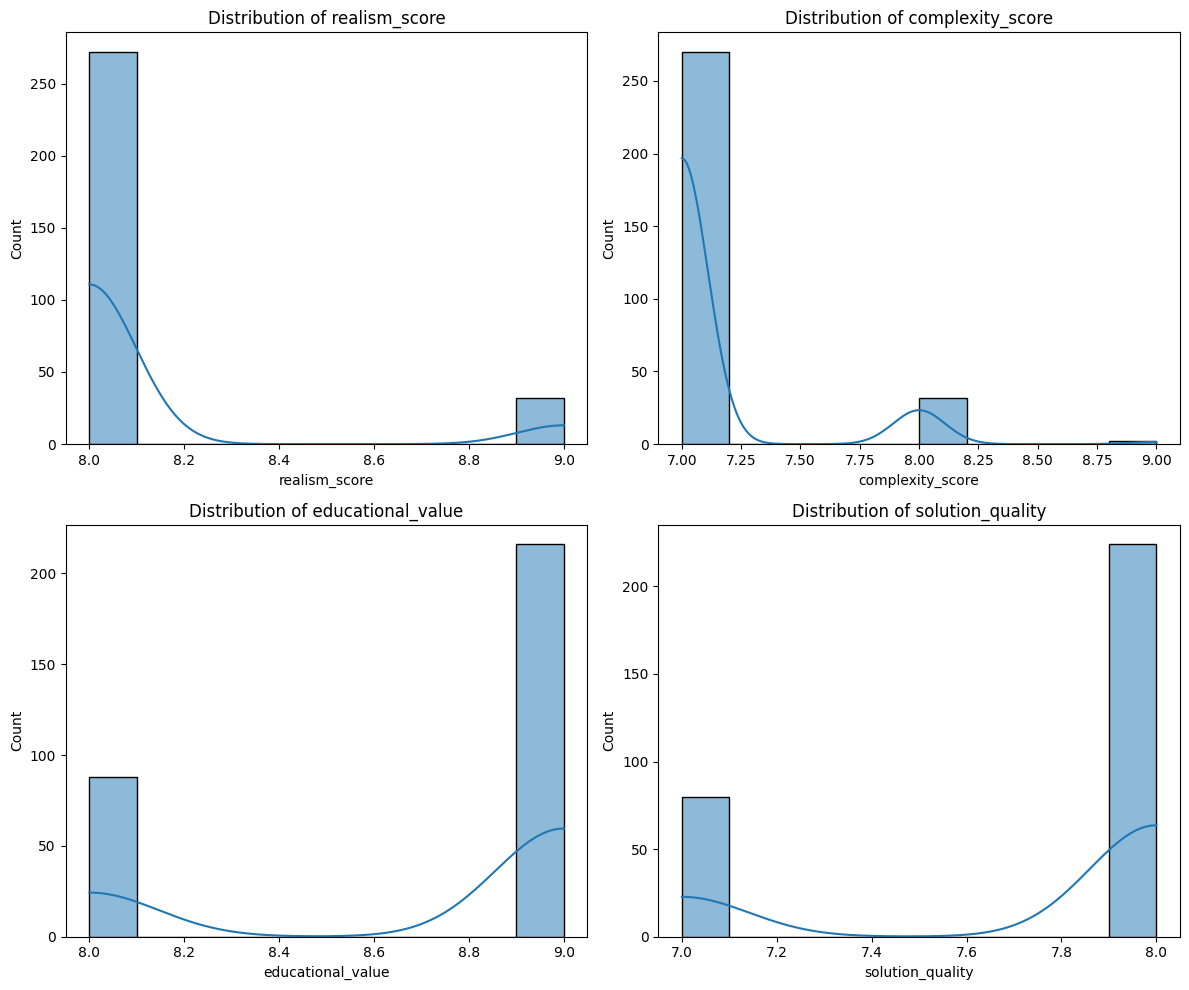

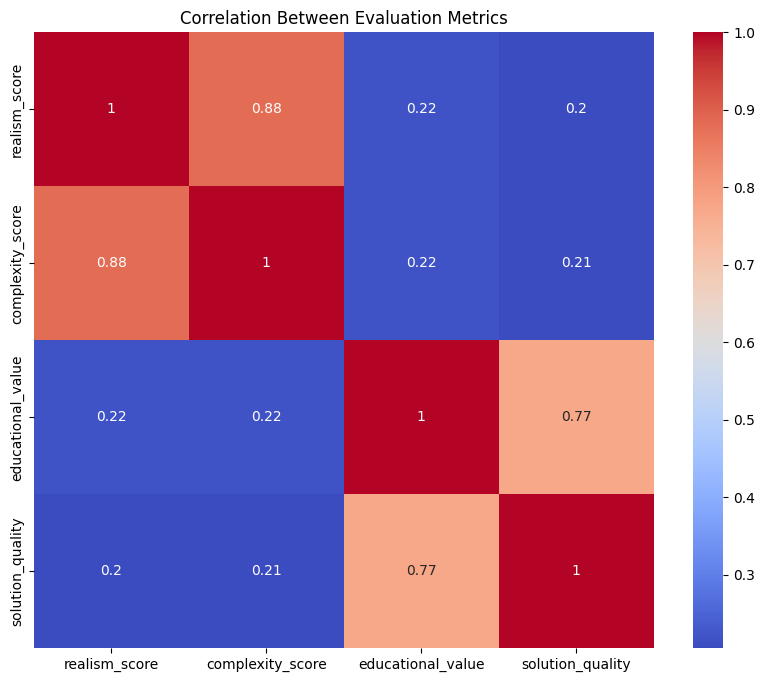

In [44]:
def analyze_evaluation_results(df):
    """Analyze the evaluation results to identify patterns and insights"""
    
    # Calculate overall statistics
    metrics = ["realism_score", "complexity_score", "educational_value", "solution_quality"]
    
    print("Overall Evaluation Metrics:")
    for metric in metrics:
        avg = df[metric].mean()
        median = df[metric].median()
        print(f"{metric}: Avg = {avg:.2f}, Median = {median:.2f}")
    
    # Count qualified vs not qualified
    qualification_counts = df["overall_qualification"].value_counts()
    print("\nQualification Results:")
    print(qualification_counts)
    
    # Calculate qualification rate
    qualified_rate = (qualification_counts.get("QUALIFIED", 0) / len(df)) * 100
    print(f"Qualification Rate: {qualified_rate:.2f}%")
    
    # Visualize the distributions
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(12, 10))
    
    # Create subplots for each metric
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        sns.histplot(df[metric], kde=True)
        plt.title(f"Distribution of {metric}")
    
    plt.tight_layout()
    plt.show()
    
    # Correlation between metrics
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[metrics].corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Between Evaluation Metrics")
    plt.show()

# Analyze the evaluation results
analyze_evaluation_results(evaluated_cases_df)

**Implementation Notes**

Evaluation Criteria: The four metrics focus on different aspects of case quality:

Realism: Accuracy of logistics procedures and regulations
Complexity: Appropriate challenge level and depth
Educational Value: Usefulness for teaching concepts
Solution Quality: Comprehensiveness and correctness

Case Qualification: The LLM will decide whether each case is "QUALIFIED" or "NOT QUALIFIED" based on its overall assessment.

Rate Limiting: We include a 10-second delay between API calls to avoid rate limits.

This notebook provides a comprehensive evaluation framework that:

- Preserves all original case data
- Adds structured quality metrics
- Uses expert evaluation with LLM's maritime domain knowledge
- Provides both quantitative scores and qualitative feedback
- Allows for filtering cases based on quality for your final selection

The exported parquet files will give us a complete dataset for further analysis and final case selection.

## Annex. Unstructured functions and try outs

In [3]:
import pandas as pd
# Read the parquet file into evaluated_cases_df
evaluated_cases_df = pd.read_parquet('/Users/max/Documents/Code/magdeburg25/Data/GeneratedCases/evaluated_cases_20250330_212702.parquet')

# Display basic information about the loaded DataFrame
print(f"Loaded {len(evaluated_cases_df)} evaluated cases")
print("\nDataFrame Info:")
print(evaluated_cases_df.info())

Loaded 307 evaluated cases

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   case_id                  307 non-null    object 
 1   title                    307 non-null    object 
 2   enhanced_case            307 non-null    object 
 3   solution                 307 non-null    object 
 4   file_path                307 non-null    object 
 5   enhanced_case_length     307 non-null    int64  
 6   solution_length          307 non-null    int64  
 7   realism_score            304 non-null    float64
 8   complexity_score         304 non-null    float64
 9   educational_value        304 non-null    float64
 10  solution_quality         304 non-null    float64
 11  overall_qualification    304 non-null    object 
 12  evaluation_summary       304 non-null    object 
 13  improvement_suggestions  304 non-nul

In [4]:
evaluated_cases_df.head()

,case_id,title,enhanced_case,solution,file_path,enhanced_case_length,solution_length,realism_score,complexity_score,educational_value,solution_quality,overall_qualification,evaluation_summary,improvement_suggestions
0,case-20250329-203754-mtqgzd,Strangled Supply Lines: Navigating Baltic Port...,"**Scenario:** Nordic Seafood Imports (NSI), a ...",## Executive Summary Nordic Seafood Imports (N...,/Users/max/Documents/Code/magdeburg25/Output/G...,7356,178919,8.0,7.0,9.0,8.0,QUALIFIED,The case study presents a realistic scenario o...,[Include a quantitative analysis of the cost-b...
1,case-20250329-210405-wqz1op,BaltSea Seafoods: Navigating Logistical Storms...,"**Scenario:** BaltSea Seafoods, a rapidly grow...",## Executive Summary BaltSea Seafoods is facin...,/Users/max/Documents/Code/magdeburg25/Output/G...,5790,8809,8.0,7.0,8.0,7.0,QUALIFIED,The case study presents a realistic scenario o...,[Include a quantitative analysis of the cost i...
2,case-20250329-002501-xcy2qu,Navigating the Baltic Supply Chain: A Plywood ...,"**Scenario:** Nordic Wood Exports (NWE), a mid...",## Executive Summary Nordic Wood Exports (NWE)...,/Users/max/Documents/Code/magdeburg25/Output/G...,8570,74328,8.0,7.0,8.0,7.0,QUALIFIED,The case study presents a realistic scenario i...,[Expand on the specific documentation required...
3,case-20250329-001222-kqjau3,The Baltic Bottleneck: Navigating Congestion a...,"**Scenario:** OceanWave Logistics, a rapidly g...",## Executive Summary OceanWave Logistics is fa...,/Users/max/Documents/Code/magdeburg25/Output/G...,6749,14069,9.0,8.0,9.0,8.0,QUALIFIED,The case study presents a highly realistic sce...,[Include a more detailed cost-benefit analysis...
4,case-20250330-080637-j1kold,**Tallinns Trade Winds: Navigating Peak Season...,"**Scenario:** BaltiCon Logistics, a mid-sized ...",## Executive Summary BaltiCon Logistics is fac...,/Users/max/Documents/Code/magdeburg25/Output/G...,6490,205247,8.0,7.0,9.0,8.0,QUALIFIED,The case study presents a realistic scenario o...,[Include specific Key Performance Indicators (...
